### Preparar dados

In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import zscore

In [168]:
df_clientes_cluster = df_vendas.groupby('codigo_cliente').agg(
    frequencia_compra=('documento', 'nunique'),
    valor_total=('total', 'sum'),
    qtd_produtos_distintos=('codigo_produto', 'nunique')
).reset_index()

In [169]:
z_scores = zscore(df_clientes_cluster[['frequencia_compra', 'valor_total', 'qtd_produtos_distintos']])
df_clientes_cluster['outlier'] = (np.abs(z_scores) > 3).any(axis=1)
df_sem_outliers = df_clientes_cluster[~df_clientes_cluster['outlier']].copy()

In [170]:
scaler = RobustScaler()
dados_normalizados = scaler.fit_transform(df_sem_outliers[['frequencia_compra', 'valor_total', 'qtd_produtos_distintos']])

### Elbow Method

k=2 -> Silhouette Score: 0.8904
k=3 -> Silhouette Score: 0.7420
k=4 -> Silhouette Score: 0.7432
k=5 -> Silhouette Score: 0.7326
k=6 -> Silhouette Score: 0.7144
k=7 -> Silhouette Score: 0.7122
k=8 -> Silhouette Score: 0.5969
k=9 -> Silhouette Score: 0.5976
k=10 -> Silhouette Score: 0.5991


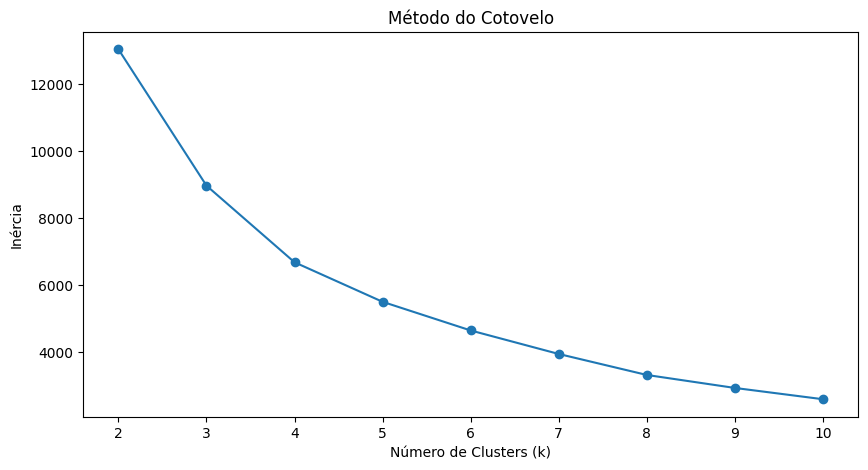

In [171]:
inercia = []
silhouettes = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20, max_iter=500, random_state=42)
    kmeans.fit(dados_normalizados)
    inercia.append(kmeans.inertia_)
    score = silhouette_score(dados_normalizados, kmeans.labels_)
    silhouettes.append(score)
    print(f"k={k} -> Silhouette Score: {score:.4f}")


plt.figure(figsize=(10,5))
plt.plot(range(2, 11), inercia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.show()

# KMeans

In [172]:
kmeans_final = KMeans(n_clusters=4, init='k-means++', n_init=20, max_iter=500, random_state=42)
clusters = kmeans_final.fit_predict(dados_normalizados)

df_sem_outliers['cluster'] = clusters

# Análises e Visualizações

#### Distribuição dos clusters

In [173]:
print("Clientes por cluster:\n", df_sem_outliers['cluster'].value_counts())

Clientes por cluster:
 cluster
0    853
2    100
1     14
3      1
Name: count, dtype: int64


#### Estatísticas por cluster

In [174]:
medias = df_sem_outliers.groupby('cluster')[['frequencia_compra', 'valor_total', 'qtd_produtos_distintos']].mean()
print("\nMédias por cluster:\n", medias)



Médias por cluster:
          frequencia_compra   valor_total  qtd_produtos_distintos
cluster                                                         
0                 1.397421    696.764982                2.604924
1                16.500000  27034.211429               55.428571
2                 5.800000   6581.289800               14.460000
3                63.000000   5040.200000               60.000000


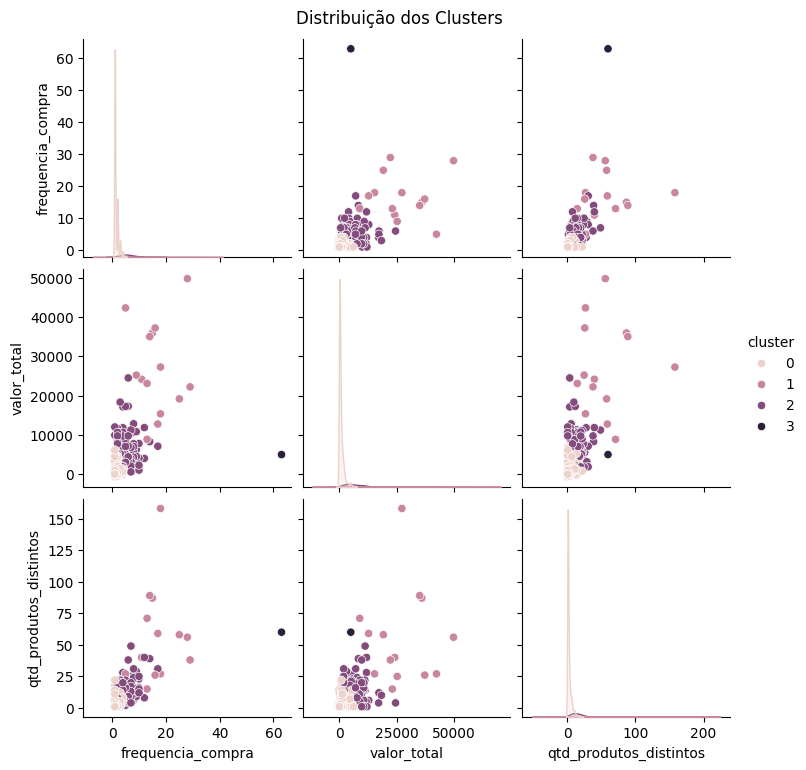

In [175]:
sns.pairplot(df_sem_outliers, hue='cluster', vars=['frequencia_compra', 'valor_total', 'qtd_produtos_distintos'])
plt.suptitle('Distribuição dos Clusters', y=1.02)
plt.show()

#### Boxplots individuais

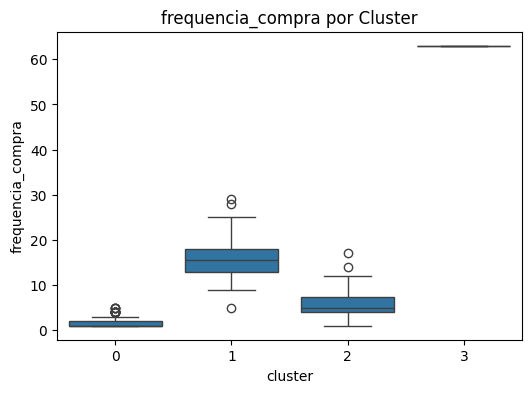

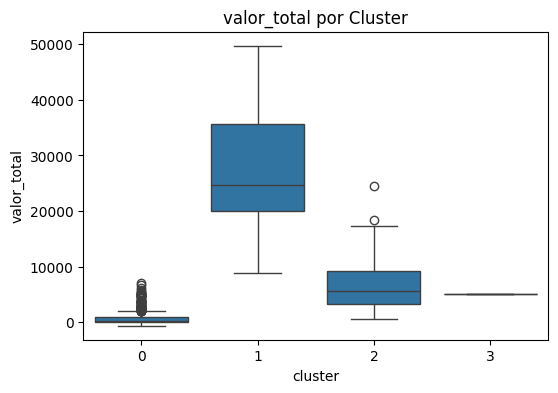

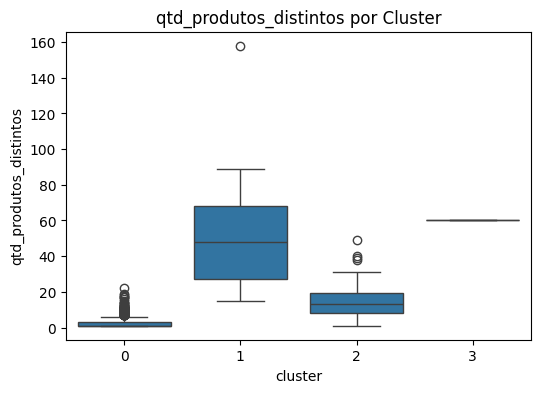

In [176]:
for coluna in ['frequencia_compra', 'valor_total', 'qtd_produtos_distintos']:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df_sem_outliers, x='cluster', y=coluna)
    plt.title(f'{coluna} por Cluster')
    plt.show()


# Documentação do processo

### Número de Clusters Testados
Foram testados valores de k variando de 2 a 10, utilizando:
- Método do Cotovelo (Elbow Method) para observar a queda na inércia (distorção intra-cluster).
- Silhouette Score, para avaliar a qualidade da separação entre os clusters.

### Justificativa da Escolha Final
A escolha final foi k = 4, com base na análise do gráfico do cotovelo, onde observou-se um ponto de inflexão nesse valor, ou seja, a partir dele a melhora na inércia se torna marginal.
- A remoção de outliers via Z-Score contribuiu para uma separação mais clara e realista entre os grupos.
- O Silhouette Score também foi satisfatório em k=4, indicando boa separação entre os clusters.

### Insights Iniciais dos Clusters (k = 4)
A clusterização com k = 4 revelou quatro perfis principais:

- Cluster: 0;  Perfil: Regulares de baixo impacto; Características: Compram pouco, gastam pouco, pouca variedade. Potencial para estímulos de compra.
- Cluster: 1;  Perfil: Clientes VIP; Características: Alta frequência, alto gasto, alta variedade. Devem ser fidelizados.
- Cluster: 2;  Perfil: Clientes intermediários; Características: Frequência e gasto medianos. Bons candidatos para crescimento com incentivos.
- Cluster: 3;  Perfil: Compradores pontuais; Características: Compras mais caras, mas pouco frequentes. Estratégia de reativação pode ajudar.